In [2]:
!pip install --upgrade numpy

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as spi
import scipy.signal as ssi
from numpy.lib.stride_tricks import sliding_window_view
import scipy.io.wavfile

In [7]:
def read_hawk(path):
  data = pd.read_csv(path)
  gyroscale = np.pi/180
  ts,xs,ys,zs = data.values[:,[1,2,3,4]].T
  return np.vstack(((ts - ts[0]) / 1e6, ys*gyroscale, zs*gyroscale, xs*gyroscale)).astype(np.float64)
def read_rc(path):
  data = pd.read_csv(path)
  gyroscale = 500 / 2**15 * np.pi/180
  ts,xs,ys,zs = data.values[:,[0,1,2,3]].T
  return np.vstack((ts/1e3, zs*gyroscale, xs*gyroscale, -ys*gyroscale)).astype(np.float64)

In [8]:
hawk_data = read_hawk('hawk.csv')
rc_data = read_rc('rc.csv')

In [9]:
def interp_to_fixed(data, smpl_interval=1/1000, include_ts=False, zero_based = False,kind='linear'):
  new_ts = np.arange(np.min(data[0]) if not zero_based else 0, np.max(data[0]), smpl_interval)
  new_xs = spi.interp1d(data[0], data[1], kind)(new_ts)
  new_ys = spi.interp1d(data[0], data[2], kind)(new_ts)
  new_zs = spi.interp1d(data[0], data[3], kind)(new_ts)
  return np.vstack((new_ts, new_xs, new_ys, new_zs)) if include_ts else np.vstack((new_xs, new_ys, new_zs))

In [10]:
def get_shift(data_a, data_b, base_s=137, search_size = 5):
  smpl_interval = 1/5000
  window_size = 1
  window_size_smpls = int(window_size // smpl_interval)
  hawk_win = sliding_window_view(interp_to_fixed(data_a, smpl_interval=smpl_interval), (3, window_size_smpls))[0]
  rc_win = sliding_window_view(interp_to_fixed(data_b,smpl_interval=smpl_interval), (3, window_size_smpls))[0]

  search_size_smpls = int(search_size // smpl_interval)
  base = int(base_s // smpl_interval)
  errors = np.array([np.sum((hawk_win[base] - rc_win[base + shift]) ** 2) for shift in range(-search_size_smpls,search_size_smpls)])
  #plt.plot(errors)
  shift_seconds = (np.argmin(errors) - search_size_smpls) * smpl_interval
  return shift_seconds

def shift_data(data_a, data_b, base_s = 137, search_size = 5):
  shift = get_shift(rc_data, hawk_data, base_s, search_size)
  return np.vstack((data_b[0] - shift, data_b[1:4]))

#print(get_shift(rc_data, hawk_data,base_s=25))
#print(get_shift(rc_data, hawk_data,base_s=80))
#print(get_shift(rc_data, hawk_data,base_s=127))
#print(get_shift(rc_data, hawk_data,base_s=176))
hawk_shift = shift_data(rc_data, hawk_data)

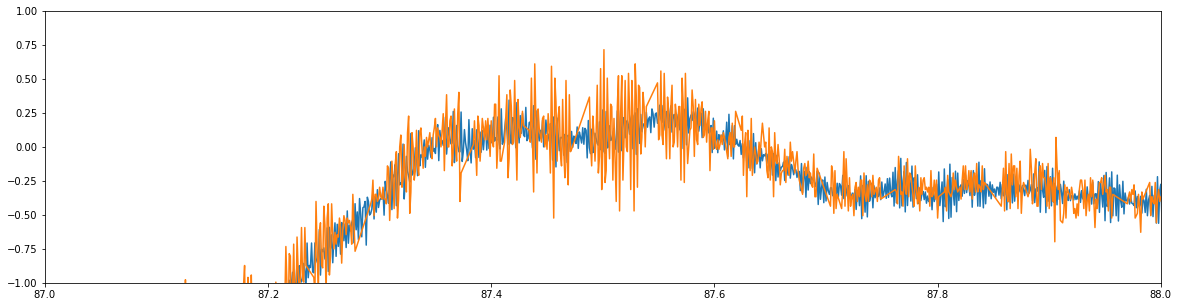

In [11]:
plt.figure(figsize=(20,5))
plt.xlim(87.000,88.000)
plt.ylim(-1,1)

plt.plot(rc_data[0], rc_data[2],'-')
plt.plot(hawk_shift[0], hawk_shift[2],'-')


In [35]:
import time as tt
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import warnings

def blackman(a):
  a_0 = .35875
  a_1 = .48829
  a_2 = .14128
  a_3 = .01168
  x=np.maximum(np.minimum(a,1.),0.)
  return a_0 - a_1 * np.cos(2 * np.pi * x) + a_2 * np.cos(4 * np.pi * x) - a_3 * np.cos(6 * np.pi * x)

def gen_basis_cos(t, state_size):
  hertz = np.arange(0, state_size)
  basis = np.cos(hertz * t * 2 * np.pi)
  return basis

def proc_axis(hawk):
  alpha = 1e-3
  state_size = 500
  window_size = .1
  window = []
  new_smpl_dt = 1e-3
  new_data = [[0],[0]]

  cc = 0
  for sample in hawk.T:
    time, value = sample[0], sample[1]

    # add new data into window
    basis = gen_basis_cos(time, state_size)
    window.append((time, basis, value))
    
    # drop old data from window
    if len(window) >= 2:
      i = 0
      while window[-1][0] - window[i + 1][0] > window_size + new_smpl_dt:
        i += 1
      window = window[i:]

    # generate new samples
    while new_data[0][-1] + new_smpl_dt < time - window_size / 2:
      new_time = new_data[0][-1] + new_smpl_dt
      window_begin, window_end = new_time - window_size / 2, new_time + window_size / 2

      # construct a least-squares problem
      sample_weights = np.expand_dims(np.array([blackman((w[0] - window_begin) / window_size) for w in window]), 1)
      equations = sample_weights * np.array([w[1] for w in window], dtype=np.float64)
      targets =  sample_weights * np.array([w[2] for w in window])[np.newaxis].T

      # solve it using RLS
      lasso = linear_model.Lasso(alpha, copy_X = False, tol = 1e-3, max_iter = 100)

      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        fit = lasso.fit(equations, targets)
      sol = fit.coef_

      new_data[0].append(new_time)
      new_data[1].append(gen_basis_cos(new_time, state_size) @ sol)

    if cc % 1024*10 == 0:
      print(time / hawk[0][-1] * 100)
    cc += 1
  return np.array(new_data, dtype = np.float64)

def proc_all(hawk_data):
  hawk_X = hawk_data[[0,1],:]
  hawk_Y = hawk_data[[0,2],:]
  hawk_Z = hawk_data[[0,3],:]
  fixed_X = proc_axis(hawk_X)
  fixed_Y = proc_axis(hawk_Y)
  fixed_Z = proc_axis(hawk_Z)
  return np.vstack((fixed_X[0], fixed_X[1], fixed_Y[1], fixed_Z[1]))

hawk_fixed = proc_all(hawk_data)


0.0
0.6741214906106403
1.3333687481739223
2.0117400196552366
2.6646126059125077
3.3142978565167738
3.9969189088687616
4.654572498605541
5.307445084862811
5.980504130255783
6.6349703843395575
7.3106855427767
7.982682142952004
8.644585513559457
9.303301548513906
9.969454699992031
10.64463863582034
11.327790910781163
11.997131397912295
12.667534330261097
13.341124598262901
13.992934739302504
14.66758745252198
15.347552391829794
16.000424978087068
16.64639167042949
17.320513161040132
18.008446439480462
18.674599590958593
19.344471300698558
20.004781003479508
20.656059921910277
21.336556083826927
21.99314722834604
22.638582698079627
23.30632951738426
23.963983107121038
24.645010491646524
25.300007968339134
25.967754787643766
26.63231427129539
27.300061090600014
27.964089351642805
28.6514914074743
29.309676219819913
29.960955138250682
30.62498339929347
31.308135674254295
31.984382055300276
32.647879093734225
33.310313686950515
33.98602884538766
34.65377566469229
35.32524104225876
35.97439507

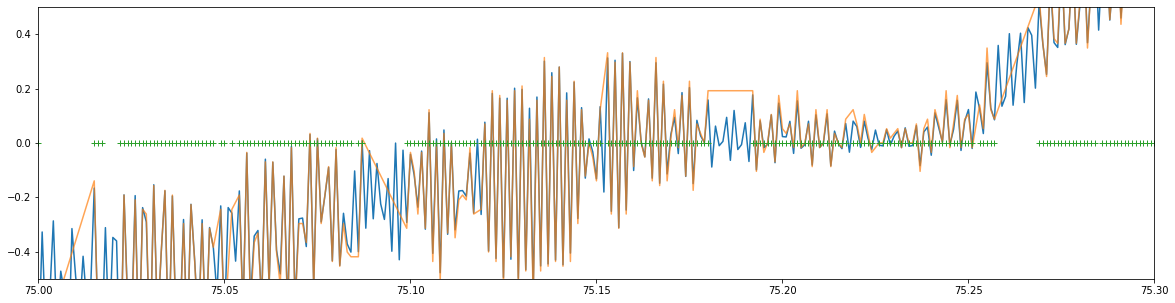

In [64]:
plt.figure(figsize=(20,5))
#plt.xlim(225.000,225.700)
#plt.xlim(20.5,20.6)
plt.xlim(75,75.3)
plt.ylim(-.5,.5)
plt.plot(hawk_fixed[0], hawk_fixed[1], '-')
plt.plot(hawk_data[0], hawk_data[1], '-', alpha=.7)
# plt.plot(hawk_data[0], hawk_data[1], '*')
#plt.plot(hawk_data_smooth[0], hawk_data_smooth[2])
#plt.plot(hawk_data_smooth_0[0], hawk_data_smooth_0[2])
plt.plot(hawk_data[0], np.zeros((len(hawk_data[0]),)),'+')

In [54]:
hawk_data_smooth = hawk_fixed

new_data = np.hstack((
      np.arange(len(hawk_data_smooth[0]))[np.newaxis].T, \
      (np.array(hawk_data_smooth[0])[np.newaxis].T + 10) * 1e6, \
      np.array(hawk_data_smooth[3])[np.newaxis].T * 180 / np.pi, \
      np.array(hawk_data_smooth[1])[np.newaxis].T * 180 / np.pi, \
      np.array(hawk_data_smooth[2])[np.newaxis].T * 180 / np.pi \
    ))
new_df = pd.DataFrame(new_data, columns=['loopIteration','time','gyroADC[0]','gyroADC[1]','gyroADC[2]'])
new_df.to_csv("hawk_smooth1000.csv",index=False)

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


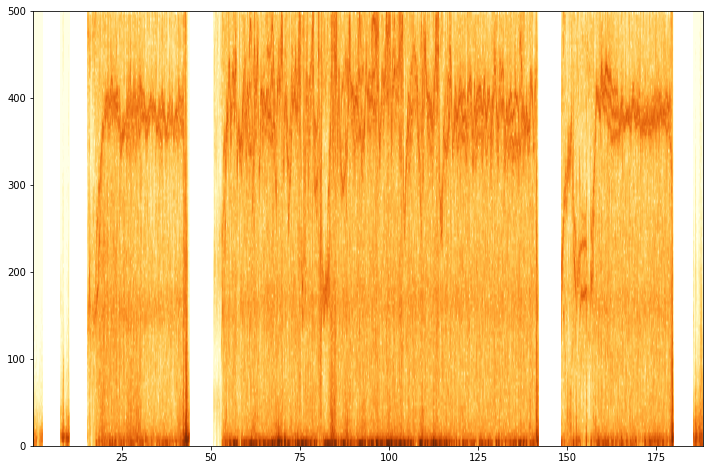

In [50]:
plt.figure(figsize=(12, 8))
plt.specgram(hawk_fixed[1], Fs=1000, cmap='YlOrBr', vmin=-100, vmax=0)
plt.axis(ymin=0, ymax=500)
None

In [53]:
scipy.io.wavfile.write('hawk_blackman.wav', 8000, np.array(hawk_data[1]))
